<a href="https://colab.research.google.com/github/gefwds/WS_project/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Цель:

Обработать данные и спроэктировать модель для изучения целевой аудитории и привлечения новых клиентов


In [ ]:
#Подключаем все нужные библеотеки
from google.colab import files

from IPython.core.pylabtools import figsize

import pandas as pd

pd.options.mode.chained_assignment = None  # default='warn
import numpy as np

import seaborn as sns
sns.set(font_scale = 2)

from sklearn.preprocessing import MinMaxScaler

from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.svm import SVR

from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [ ]:
#Подгружаем данные
files.upload()
!ls
RawData = pd.read_csv('marketing_data.csv')
RawData

Saving marketing_data.csv to marketing_data.csv
drive  marketing_data.csv  sample_data


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Country
0,1826,1970,Graduation,Divorced,"$84,835.00",0,0,6/16/14,0,189,104,379,111,189,218,1,4,4,6,1,0,0,0,0,0,1,0,SP
1,1,1961,Graduation,Single,"$57,091.00",0,0,6/15/14,0,464,5,64,7,0,37,1,7,3,7,5,0,0,0,0,1,1,0,CA
2,10476,1958,Graduation,Married,"$67,267.00",0,1,5/13/14,0,134,11,59,15,2,30,1,3,2,5,2,0,0,0,0,0,0,0,US
3,1386,1967,Graduation,Together,"$32,474.00",1,1,5/11/14,0,10,0,1,0,0,0,1,1,0,2,7,0,0,0,0,0,0,0,AUS
4,5371,1989,Graduation,Single,"$21,474.00",1,0,4/8/14,0,6,16,24,11,0,34,2,3,1,2,7,1,0,0,0,0,1,0,SP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10142,1976,PhD,Divorced,"$66,476.00",0,1,3/7/13,99,372,18,126,47,48,78,2,5,2,11,4,0,0,0,0,0,0,0,US
2236,5263,1977,2n Cycle,Married,"$31,056.00",1,0,1/22/13,99,5,10,13,3,8,16,1,1,0,3,8,0,0,0,0,0,0,0,SP
2237,22,1976,Graduation,Divorced,"$46,310.00",1,0,12/3/12,99,185,2,88,15,5,14,2,6,1,5,8,0,0,0,0,0,0,0,SP
2238,528,1978,Graduation,Married,"$65,819.00",0,0,11/29/12,99,267,38,701,149,165,63,1,5,4,10,3,0,0,0,0,0,0,0,IND


1) Знакомство и обработка данных 

In [ ]:
RawData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   2240 non-null   int64 
 1   Year_Birth           2240 non-null   int64 
 2   Education            2240 non-null   object
 3   Marital_Status       2240 non-null   object
 4    Income              2216 non-null   object
 5   Kidhome              2240 non-null   int64 
 6   Teenhome             2240 non-null   int64 
 7   Dt_Customer          2240 non-null   object
 8   Recency              2240 non-null   int64 
 9   MntWines             2240 non-null   int64 
 10  MntFruits            2240 non-null   int64 
 11  MntMeatProducts      2240 non-null   int64 
 12  MntFishProducts      2240 non-null   int64 
 13  MntSweetProducts     2240 non-null   int64 
 14  MntGoldProds         2240 non-null   int64 
 15  NumDealsPurchases    2240 non-null   int64 
 16  NumWeb

In [ ]:
#Проверяем датасет на наличие пропусков
def missing_values_table(df):

        mis_val = df.isnull().sum()
        

        mis_val_percent = 100 * df.isnull().sum() / len(df)

        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        

        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        

        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        

        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        

        return mis_val_table_ren_columns

In [ ]:
missing_values_table(RawData)

Your selected dataframe has 28 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
Income,24,1.1


In [ ]:
RawData = RawData.dropna()

In [ ]:
missing_values_table(RawData)

Your selected dataframe has 28 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


Нужно получить общее кол-во прдуктов - это будет целевой функцией


In [ ]:
RawData['Mnt'] = RawData[['MntWines',	'MntFruits',	'MntMeatProducts',	'MntFishProducts',	'MntSweetProducts',	'MntGoldProds']].sum(axis=1)

In [ ]:
RawData = RawData.drop(columns=['MntWines',	'MntFruits',	'MntMeatProducts',	'MntFishProducts',	'MntSweetProducts',	'MntGoldProds'])

In [ ]:
RawData.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Country,Mnt
0,1826,1970,Graduation,Divorced,"$84,835.00",0,0,6/16/14,0,1,4,4,6,1,0,0,0,0,0,1,0,SP,1190
1,1,1961,Graduation,Single,"$57,091.00",0,0,6/15/14,0,1,7,3,7,5,0,0,0,0,1,1,0,CA,577
2,10476,1958,Graduation,Married,"$67,267.00",0,1,5/13/14,0,1,3,2,5,2,0,0,0,0,0,0,0,US,251
3,1386,1967,Graduation,Together,"$32,474.00",1,1,5/11/14,0,1,1,0,2,7,0,0,0,0,0,0,0,AUS,11
4,5371,1989,Graduation,Single,"$21,474.00",1,0,4/8/14,0,2,3,1,2,7,1,0,0,0,0,1,0,SP,91


In [ ]:
#строки  Id, Dt_Customer не несет в себе ценности для исследования -> удаляем их
RawData = RawData.drop(columns=['ID', 'Dt_Customer'])

In [ ]:
#Столбец Income содержит важную информацию о доходе клиента, но представлен в некомфортном для обработки и анализа виде. Изменим его для комфортной работы
import string
RawData = RawData.replace(r'[{}]'.format(string.punctuation), '', regex=True)
RawData[' Income '] = pd.to_numeric(RawData[' Income '])
RawData[' Income '] /= 100

2) Однопеременные графики и проверка датасета на наличие выбросов

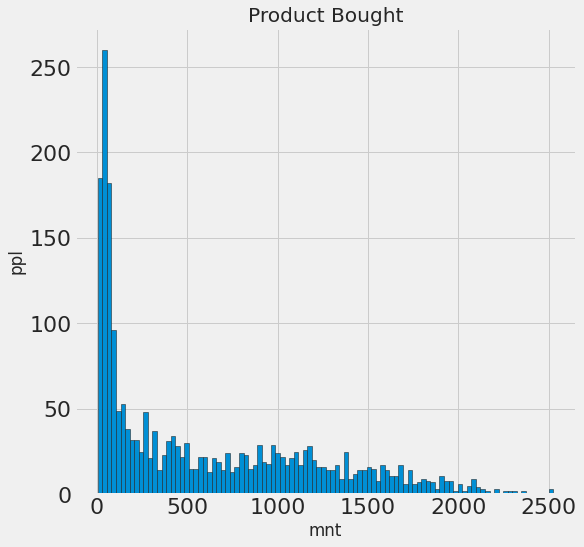

In [ ]:
#График целевой функции
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
%matplotlib inline
figsize(8, 8)
plt.style.use('fivethirtyeight')
plt.hist(RawData['Mnt'].dropna(), bins = 100, edgecolor = 'k');
plt.xlabel('mnt'); plt.ylabel('ppl'); 
plt.title('Product Bought');

График имеет сильный перекос. Так же имеются выбросы. Попытаемся что-то с этим сделать

In [ ]:
RawData['Mnt'].describe()

count    2216.000000
mean      607.075361
std       602.900476
min         5.000000
25%        69.000000
50%       396.500000
75%      1048.000000
max      2525.000000
Name: Mnt, dtype: float64

In [ ]:
#Попытаемся избавиться от выбросов с помощью интерквартильного расстояния
first_quartile = RawData['Mnt'].describe()['25%']
third_quartile = RawData['Mnt'].describe()['75%']

iqr = third_quartile - first_quartile

RawData = RawData[(RawData['Mnt'] > (first_quartile -  iqr)) &
            (RawData['Mnt'] < (third_quartile + iqr))]

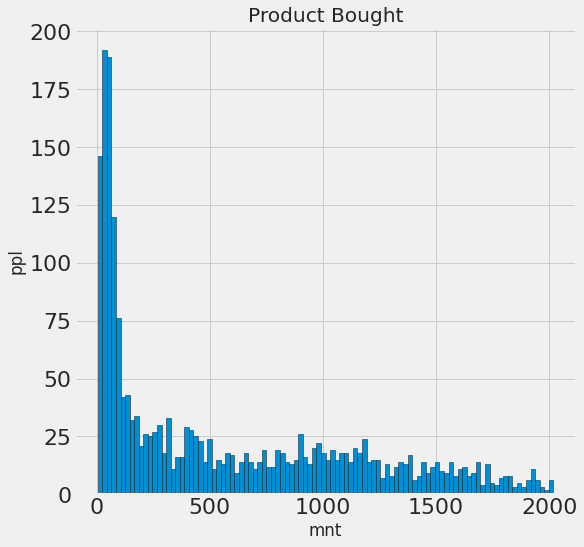

In [ ]:
#Выгядит уже лучше, к сожалению придется работать с такими данными, так как наблюдений не очень много
figsize(8, 8)
plt.style.use('fivethirtyeight')
plt.hist(RawData['Mnt'].dropna(), bins = 100, edgecolor = 'k');
plt.xlabel('mnt'); plt.ylabel('ppl'); 
plt.title('Product Bought');

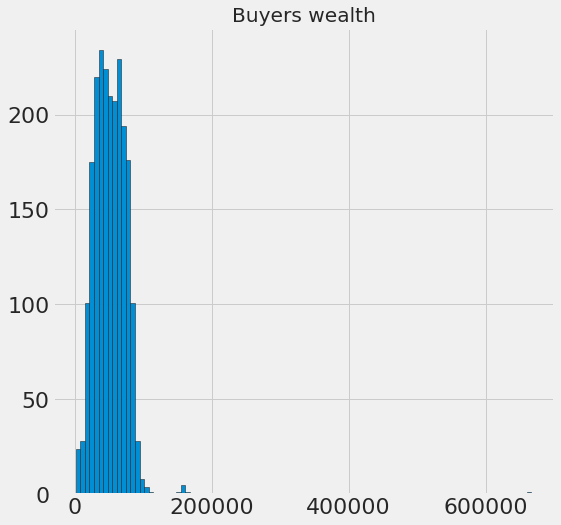

In [ ]:
#По графику видно наличие выбросов
figsize(8, 8)

plt.hist(RawData[' Income '].dropna(), bins = 100, edgecolor = 'k');
plt.xlabel(''); plt.ylabel(''); 
plt.title('Buyers wealth');

In [ ]:
RawData[' Income '].describe()

count      2172.000000
mean      51631.679558
std       25022.424766
min        1730.000000
25%       34930.250000
50%       50733.000000
75%       67421.750000
max      666666.000000
Name:  Income , dtype: float64

In [ ]:
RawData[' Income '].sort_values().tail(10)

832     105471.0
210     113734.0
1826    153924.0
1925    156924.0
325     157146.0
2204    157243.0
853     157733.0
497     160803.0
731     162397.0
527     666666.0
Name:  Income , dtype: float64

In [ ]:
#Значение в строке 527 некорректно -> Удаляем
RawData = RawData.drop(index=527)


In [ ]:
RawData[' Income '].sort_values().tail(10)

142     102692.0
832     105471.0
210     113734.0
1826    153924.0
1925    156924.0
325     157146.0
2204    157243.0
853     157733.0
497     160803.0
731     162397.0
Name:  Income , dtype: float64

In [ ]:
# Посмотрим на корреляции целефой функции с данными
correlations_data = RawData.corr()['Mnt'].sort_values()

print(correlations_data.head(23), '\n')

Kidhome               -0.560718
NumWebVisitsMonth     -0.488713
Year_Birth            -0.130122
Teenhome              -0.101590
Complain              -0.034816
NumDealsPurchases     -0.027684
Recency                0.014247
AcceptedCmp3           0.037567
AcceptedCmp2           0.145057
AcceptedCmp4           0.228403
Response               0.231297
AcceptedCmp1           0.336071
AcceptedCmp5           0.427297
NumWebPurchases        0.546353
NumStorePurchases      0.684984
NumCatalogPurchases    0.784661
 Income                0.790667
Mnt                    1.000000
Name: Mnt, dtype: float64 



Не зря мы обратили внимание на столбец Income и избавились от выбросов. У этотого столбца самая сильная корреляция с целевой функцией

3)Feature engeneering

In [ ]:
#Возьмем натуральные логарифмы от числовых данных и категоризируем данные
features = RawData.copy()
numeric_subset = RawData.select_dtypes('number')

for col in numeric_subset.columns:
  if col == 'Mnt':
    next
  else:
      numeric_subset['log_' + col] = np.log(numeric_subset[col])
  
categorical_subset = RawData[['Education', 'Marital_Status', 'Country']]

categorical_subset = pd.get_dummies(categorical_subset)

features = pd.concat([numeric_subset, categorical_subset], axis = 1)

features.shape

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


(2171, 56)

In [ ]:
features

,Year_Birth,Income,Kidhome,Teenhome,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Mnt,log_Year_Birth,log_ Income,log_Kidhome,log_Teenhome,log_Recency,log_NumDealsPurchases,log_NumWebPurchases,log_NumCatalogPurchases,log_NumStorePurchases,log_NumWebVisitsMonth,log_AcceptedCmp3,log_AcceptedCmp4,log_AcceptedCmp5,log_AcceptedCmp1,log_AcceptedCmp2,log_Response,log_Complain,Education_2n Cycle,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Absurd,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO,Country_AUS,Country_CA,Country_GER,Country_IND,Country_ME,Country_SA,Country_SP,Country_US
0,1970,84835.0,0,0,0,1,4,4,6,1,0,0,0,0,0,1,0,1190,7.585789,11.348463,-inf,-inf,-inf,0.000000,1.386294,1.386294,1.791759,0.000000,-inf,-inf,-inf,-inf,-inf,0.0,-inf,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1,1961,57091.0,0,0,0,1,7,3,7,5,0,0,0,0,1,1,0,577,7.581210,10.952402,-inf,-inf,-inf,0.000000,1.945910,1.098612,1.945910,1.609438,-inf,-inf,-inf,-inf,0.0,0.0,-inf,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
2,1958,67267.0,0,1,0,1,3,2,5,2,0,0,0,0,0,0,0,251,7.579679,11.116425,-inf,0.000000,-inf,0.000000,1.098612,0.693147,1.609438,0.693147,-inf,-inf,-inf,-inf,-inf,-inf,-inf,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
3,1967,32474.0,1,1,0,1,1,0,2,7,0,0,0,0,0,0,0,11,7.584265,10.388195,0.0,0.000000,-inf,0.000000,0.000000,-inf,0.693147,1.945910,-inf,-inf,-inf,-inf,-inf,-inf,-inf,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
4,1989,21474.0,1,0,0,2,3,1,2,7,1,0,0,0,0,1,0,91,7.595387,9.974598,0.0,-inf,-inf,0.693147,1.098612,0.000000,0.693147,1.945910,0.0,-inf,-inf,-inf,-inf,0.0,-inf,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,1976,66476.0,0,1,99,2,5,2,11,4,0,0,0,0,0,0,0,689,7.588830,11.104596,-inf,0.000000,4.59512,0.693147,1.609438,0.693147,2.397895,1.386294,-inf,-inf,-inf,-inf,-inf,-inf,-inf,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
2236,1977,31056.0,1,0,99,1,1,0,3,8,0,0,0,0,0,0,0,55,7.589336,10.343547,0.0,-inf,4.59512,0.000000,0.000000,-inf,1.098612,2.079442,-inf,-inf,-inf,-inf,-inf,-inf,-inf,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
2237,1976,46310.0,1,0,99,2,6,1,5,8,0,0,0,0,0,0,0,309,7.588830,10.743113,0.0,-inf,4.59512,0.693147,1.791759,0.000000,1.609438,2.079442,-inf,-inf,-inf,-inf,-inf,-inf,-inf,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
2238,1978,65819.0,0,0,99,1,5,4,10,3,0,0,0,0,0,0,0,1383,7.589842,11.094664,-inf,-inf,4.59512,0.000000,1.609438,1.386294,2.302585,1.098612,-inf,-inf,-inf,-inf,-inf,-inf,-inf,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0


In [ ]:
no_Mnt = features[features['Mnt'].isna()]
Mnt = features[features['Mnt'].notnull()]

print(no_Mnt.shape)
print(Mnt.shape)

(0, 56)
(2171, 56)


In [ ]:
#Разобьем данные на тестовую и проверочную выборку
from sklearn.model_selection import train_test_split
features = Mnt.drop(columns='Mnt')
targets = pd.DataFrame(Mnt['Mnt'])

features = features.replace({np.inf: np.nan, -np.inf: np.nan})

train_features, test_features, train_labels, test_labels = train_test_split(features, targets, test_size = 0.3, random_state = 42)




4)Выбор метрики 

В качестве метрики я выбрал MAE (Средняя абсолютная ошибка) так как она легко вычесляема и хорошо интерпретируема для данной модели

In [ ]:
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

In [ ]:
#Вычесляем показатель для исходного базового уровня
baseline_guess = np.median(train_labels)
print('The baseline guess is a score of %0.2f' % baseline_guess)
print("Baseline Performance on the test set: MAE = %0.4f" % mae(test_labels, baseline_guess))

The baseline guess is a score of 395.00
Baseline Performance on the test set: MAE = 494.8451


Из-за перекоса данных базовый уровень имеет существенную ошибку в 514 покупок 

In [ ]:
#Заполняем отстутсвующие значения 
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')


imputer.fit(train_features)


X = imputer.transform(train_features)
X_test = imputer.transform(test_features)

In [ ]:
print('Missing values in training features: ', np.sum(np.isnan(X)))
print('Missing values in testing features:  ', np.sum(np.isnan(X_test)))

Missing values in training features:  0
Missing values in testing features:   0


In [ ]:
print(np.where(~np.isfinite(X)))
print(np.where(~np.isfinite(X_test)))

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


5) Масштабирование признаков

In [ ]:
#Масштабируем данные от 0-1
scaler = MinMaxScaler(feature_range=(0, 1))


scaler.fit(X)


X = scaler.transform(X)
X_test = scaler.transform(X_test)

In [ ]:
#Преобразуем в вектор
y = np.array(train_labels).reshape((-1, ))
y_test = np.array(test_labels).reshape((-1, ))

NameError: ignored

6)Выбор модели обучения
Для обучения модели мы рассмотрим 5 моделей:

1)Линейная регрессия.

2)Метод k-ближайших соседей.

3)«Случайный лес».

4)Градиентный бустинг.

5)Метод опорных векторов.


In [ ]:
def fit_and_evaluate(model):
    
    
    model.fit(X, y)
    
    
    model_pred = model.predict(X_test)
    model_mae = mae(y_test, model_pred)
    
  
    return model_mae

In [ ]:
lr = LinearRegression()
lr_mae = fit_and_evaluate(lr)

print('Linear Regression Performance on the test set: MAE = %0.4f' % lr_mae)

Linear Regression Performance on the test set: MAE = 165.9402


In [ ]:
random_forest = RandomForestRegressor(random_state=17)
random_forest_mae = fit_and_evaluate(random_forest)

print('Random Forest Regression Performance on the test set: MAE = %0.4f' % random_forest_mae)

Random Forest Regression Performance on the test set: MAE = 100.6178


In [ ]:
gradient_boosted = GradientBoostingRegressor(random_state=60)
gradient_boosted_mae = fit_and_evaluate(gradient_boosted)

print('Gradient Boosted Regression Performance on the test set: MAE = %0.4f' % gradient_boosted_mae)

Gradient Boosted Regression Performance on the test set: MAE = 110.2321


In [ ]:
knn = KNeighborsRegressor(n_neighbors=10)
knn_mae = fit_and_evaluate(knn)

print('K-Nearest Neighbors Regression Performance on the test set: MAE = %0.4f' % knn_mae)

K-Nearest Neighbors Regression Performance on the test set: MAE = 260.5916


In [ ]:
svm = SVR(C = 1000, gamma = 0.1)
svm_mae = fit_and_evaluate(svm)

print('Support Vector Machine Regression Performance on the test set: MAE = %0.4f' % svm_mae)

Support Vector Machine Regression Performance on the test set: MAE = 147.4888


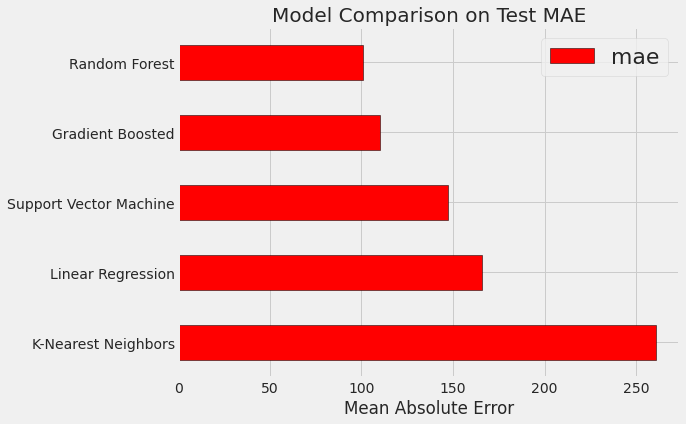

In [ ]:
plt.style.use('fivethirtyeight')
figsize(8, 6)


model_comparison = pd.DataFrame({'model': ['Linear Regression', 'Support Vector Machine',
                                           'Random Forest', 'Gradient Boosted',
                                            'K-Nearest Neighbors'],
                                 'mae': [lr_mae, svm_mae, random_forest_mae, 
                                         gradient_boosted_mae, knn_mae]})

model_comparison.sort_values('mae', ascending = False).plot(x = 'model', y = 'mae', kind = 'barh',
                                                           color = 'red', edgecolor = 'black')


plt.ylabel(''); plt.yticks(size = 14); plt.xlabel('Mean Absolute Error'); plt.xticks(size = 14)
plt.title('Model Comparison on Test MAE', size = 20);

Судя по графику наибольшую эффективность показал «Случайный лес».

Его и будем использовать

7)Настройка гиперпараметров

In [ ]:



n_estimators = [100, 500, 900, 1100, 1500]


max_depth = [2, 3, 5, 10, 15]


min_samples_leaf = [1, 2, 4, 6, 8]


min_samples_split = [2, 4, 6, 10]


max_features = ['auto', 'sqrt', 'log2', None]

bootstrap = [True, False]

hyperparameter_grid = {
                       'n_estimators': n_estimators,
                       'max_depth': max_depth,
                       'min_samples_leaf': min_samples_leaf,
                       'min_samples_split': min_samples_split,
                       'max_features': max_features}

In [ ]:
model = RandomForestRegressor(random_state = 42)


random_cv = RandomizedSearchCV(estimator=model,
                               param_distributions=hyperparameter_grid,
                               cv=4, n_iter=25, 
                               scoring = 'neg_mean_absolute_error',
                               n_jobs = -1, verbose = 1, 
                               return_train_score = True,
                               random_state=42)

In [ ]:
random_cv.fit(X, y)
random_cv.best_params_

Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.5min


KeyboardInterrupt: ignored

In [ ]:
random_results = pd.DataFrame(random_cv.cv_results_).sort_values('mean_test_score', ascending = False)
random_results.head(10)

AttributeError: ignored

In [ ]:
random_cv.best_estimator_

AttributeError: ignored

NameError: ignored

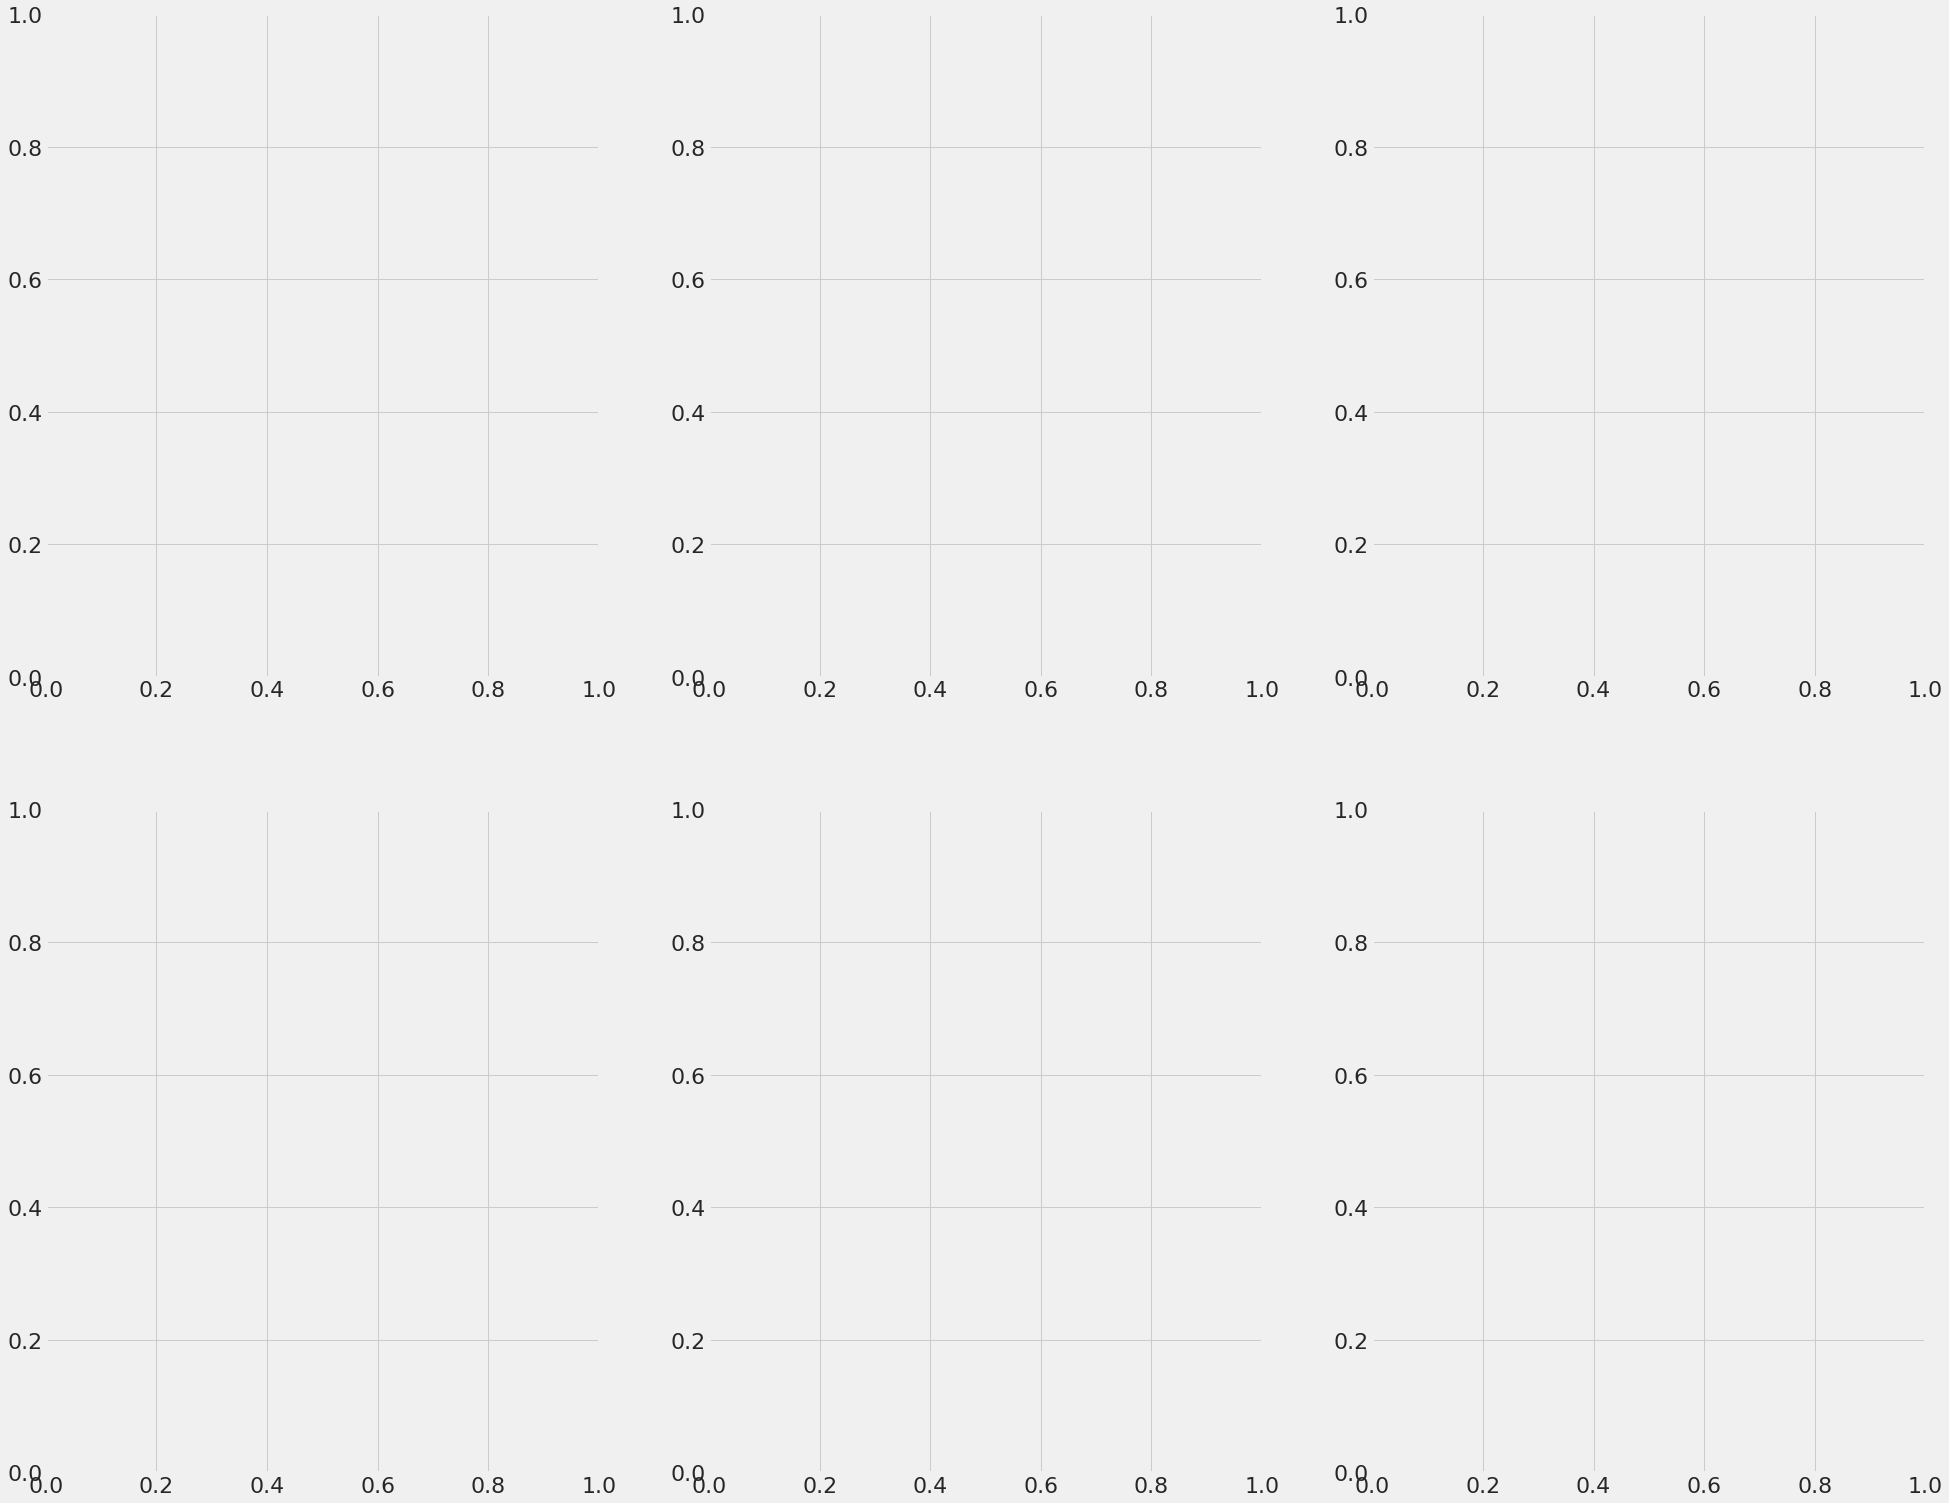

In [ ]:
fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(30,25)
sns.barplot(x='param_n_estimators', y='mean_test_score', data=random_results, ax=axs[0,0], color='lightgrey')
sns.barplot(x='param_min_samples_split', y='mean_test_score', data=random_results, ax=axs[0,1], color='coral')
sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=random_results, ax=axs[0,2], color='lightgreen')
sns.barplot(x='param_max_features', y='mean_test_score', data=random_results, ax=axs[1,0], color='wheat')
sns.barplot(x='param_max_depth', y='mean_test_score', data=random_results, ax=axs[1,1], color='lightpink')
plt.show()

Исходя из графика наибольшую эффективность модель имеет со следующими гиперпараметрами:

n_estimators=900

max_depth = 10

min_samples_leaf =8

min_samples_split =2,

max_features = 'auto'

In [ ]:
trees_grid = {'n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 1100]}

model = RandomForestRegressor(max_depth = 10,
                                  min_samples_leaf =8,
                                  min_samples_split =2,
                                  max_features = 'auto',
                                  random_state = 42)

grid_search = GridSearchCV(estimator = model, param_grid=trees_grid, cv = 4, 
                           scoring = 'neg_mean_absolute_error', verbose = 1,
                           n_jobs = -1, return_train_score = True)

In [ ]:
grid_search.fit(X, y)

KeyboardInterrupt: ignored

In [ ]:
results.sort_values('mean_test_score', ascending = False).head(5)

NameError: ignored

Сравним модели для проверки настройки

In [ ]:
default_model = RandomForestRegressor(random_state = 42)

final_model = RandomForestRegressor(max_depth = 10,
                                  min_samples_leaf =1,
                                  min_samples_split =2,
                                  max_features = 'auto',
                                  n_estimators=900,
                                  random_state = 42)

final_model

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=900, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [ ]:
%%timeit -n 1 -r 5
default_model.fit(X, y)

1 loop, best of 5: 1.18 s per loop


In [ ]:
%%timeit -n 1 -r 5
final_model.fit(X, y)

1 loop, best of 5: 8.04 s per loop


In [ ]:
default_pred = default_model.predict(X_test)
final_pred = final_model.predict(X_test)

print('Default model performance on the test set: MAE = %0.4f.' % mae(y_test, default_pred))
print('Final model performance on the test set:   MAE = %0.4f.' % mae(y_test, final_pred))

Default model performance on the test set: MAE = 100.6627.
Final model performance on the test set:   MAE = 101.5926.


Почему-то ненастроенная модель работает лучше.

Попытки настройки гиперпараметров не привели к улучшению.

Для обучения будем использовать ненастроенную модель.

8)Результаты обучения

Text(0.5, 1.0, 'Test Values and Predictions')

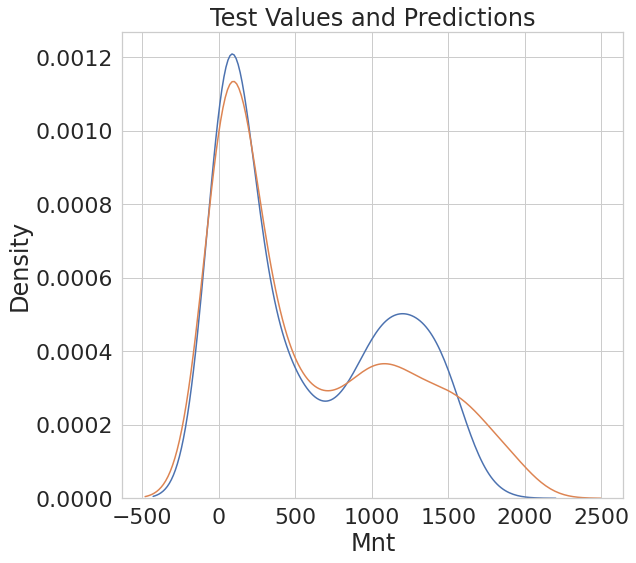

In [ ]:
figsize(8, 8)


sns.kdeplot(default_pred, label = 'Predictions')
sns.kdeplot(y_test, label = 'Values')


plt.xlabel('Mnt'); plt.ylabel('Density');
plt.title('Test Values and Predictions')

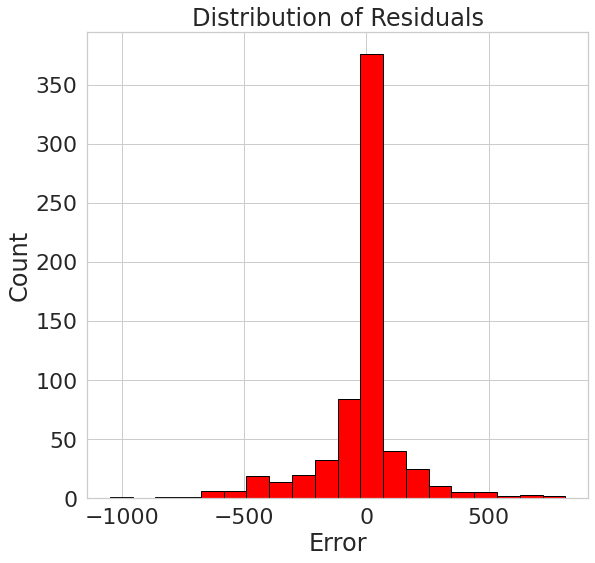

In [ ]:
figsize = (6, 6)

# Calculate the residuals 
residuals = default_pred - y_test

# Plot the residuals in a histogram
plt.hist(residuals, color = 'red', bins = 20,
         edgecolor = 'black')
plt.xlabel('Error'); plt.ylabel('Count')
plt.title('Distribution of Residuals');

9)Выводы

По графикам выше видно, что модель в большенстве случаев работает удачно.

Средняя ошибка составила 119 покупок в год, что я считаю приемлемым для наших целей.